In [1]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

import cvxopt as opt
from cvxopt import blas, solvers

/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [20]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['DHR','GILD','ISRG','JNJ','LLY','PFE','REGN','TMO','AZN','MRK']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)        # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'                # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [21]:
len(stocks)

10

In [22]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  10 of 10 completed


In [23]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2009-01-02,5495.0,5109.0,6797.0,2544.0,3912.0,10117.0,5347.0,2965.0,9201.0,5686.0


In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from pypfopt import risk_models, expected_returns

# Function to calculate portfolio risk
def calculate_portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate risk contributions
def risk_contribution(weights, cov_matrix):
    portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
    return (weights * np.dot(cov_matrix, weights)) / portfolio_risk

# Objective function to minimize
def risk_parity_objective(weights, args):
    cov_matrix = args[0]
    risk_target = args[1]
    asset_risk = risk_contribution(weights, cov_matrix)
    return np.sum(np.square(asset_risk - risk_target))

# Constraint for the optimization problem
def weight_sum_constraint(x):
    return np.sum(x) - 1.0

# Assuming you have a DataFrame 'stock_data' with historical stock prices
# Replace this with your actual data


df = stock_data.copy()
num_assets = len(df.columns)
stocks = df.columns

# Create a DataFrame to store the optimal portfolio weights over time
optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# Set the window length for the rolling covariance calculation
window_length = 424  # Use 252 for approximately one year of trading days

# Set the initial weights to be equal for all assets
initial_weights = np.array([1 / num_assets] * num_assets)

for end_date in df.index[window_length:]:
    # Extract the window of data
    data_window = df.loc[:end_date].tail(window_length)

    # Calculate expected returns and the covariance matrix for the window
    mu = expected_returns.mean_historical_return(data_window)
    S = risk_models.sample_cov(data_window)

    # Risk Parity Optimization
    constraints = ({'type': 'eq', 'fun': weight_sum_constraint})
    risk_target = np.repeat(1 / num_assets, num_assets)
    args = [S, risk_target]

    solution = minimize(risk_parity_objective, initial_weights, args=args,
                        constraints=constraints, bounds=[(0, 1) for asset in range(num_assets)])

    optimal_weights = solution.x

    # Add the weights to our optimal_weights DataFrame
    optimal_weights_df.loc[end_date] = optimal_weights

# Forward-fill the weights for the days when we're not rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# Print out the final DataFrame
print(optimal_weights_df.tail())


                     DHR      GILD      ISRG           JNJ       LLY  \
Date                                                                   
2015-12-18  0.000000e+00  0.192604  0.179200  0.000000e+00  0.160681   
2015-12-21  0.000000e+00  0.198058  0.177741  1.933923e-17  0.159245   
2015-12-22  0.000000e+00  0.198105  0.177192  4.854412e-18  0.160348   
2015-12-23  0.000000e+00  0.195662  0.179571  0.000000e+00  0.159659   
2015-12-24  2.867124e-17  0.195357  0.163308  2.015446e-17  0.161646   

                     PFE      REGN       TMO           AZN       MRK  
Date                                                                  
2015-12-18  0.000000e+00  0.193296  0.149122  0.000000e+00  0.125096  
2015-12-21  0.000000e+00  0.192014  0.149021  0.000000e+00  0.123920  
2015-12-22  0.000000e+00  0.188705  0.150440  0.000000e+00  0.125210  
2015-12-23  0.000000e+00  0.192406  0.149734  0.000000e+00  0.122969  
2015-12-24  1.121758e-16  0.191291  0.155134  9.163563e-17  0.133264 

In [25]:
start_date = df.index[window_length]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]
optimal_weights_df = optimal_weights_df.loc[start_date:]


In [26]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2010-09-09,4007.0,7830.0,3181.0,2431.0,4096.0,10143.0,4065.0,2290.0,6562.0,4536.0


In [27]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]

        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares

        balance_year = day.year
        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [28]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [29]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [30]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [31]:
stock_data.filter(regex='weight')

,DHR_weight,GILD_weight,ISRG_weight,JNJ_weight,LLY_weight,PFE_weight,REGN_weight,TMO_weight,AZN_weight,MRK_weight
Date,,,,,,,,,,
2010-09-10,0.099526,0.100280,0.098274,0.099528,0.100013,0.100585,0.101511,0.099481,0.099960,0.100841
2010-09-13,0.100481,0.099706,0.097478,0.099519,0.099721,0.099891,0.102896,0.100679,0.099503,0.100126
2010-09-14,0.099803,0.099403,0.099114,0.099298,0.099406,0.099885,0.102307,0.100409,0.100076,0.100298
2010-09-15,0.098914,0.099807,0.101274,0.099524,0.099004,0.100446,0.101829,0.100097,0.099380,0.099725
2010-09-16,0.099102,0.100070,0.100651,0.099806,0.098813,0.099756,0.102985,0.100073,0.099347,0.099398
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,0.000000,0.193523,0.208770,0.000000,0.149511,0.000000,0.198612,0.146125,0.000000,0.103458
2015-12-21,0.000000,0.194375,0.209582,0.000000,0.150889,0.000000,0.193246,0.148578,0.000000,0.103329
2015-12-22,0.000000,0.194401,0.209968,0.000000,0.150345,0.000000,0.191316,0.150401,0.000000,0.103569


In [32]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [33]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [34]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [35]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [36]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.31,2011-04-27,2011-08-10,2012-01-06,183
1,18.13,2014-03-04,2014-04-28,2014-08-25,125
2,15.03,2015-08-05,2015-09-28,NaT,NaN
3,8.57,2012-04-27,2012-05-18,2012-07-27,66
4,8.49,2014-10-08,2014-10-15,2014-10-21,10


AttributeError: 'Axes' object has no attribute 'is_last_row'

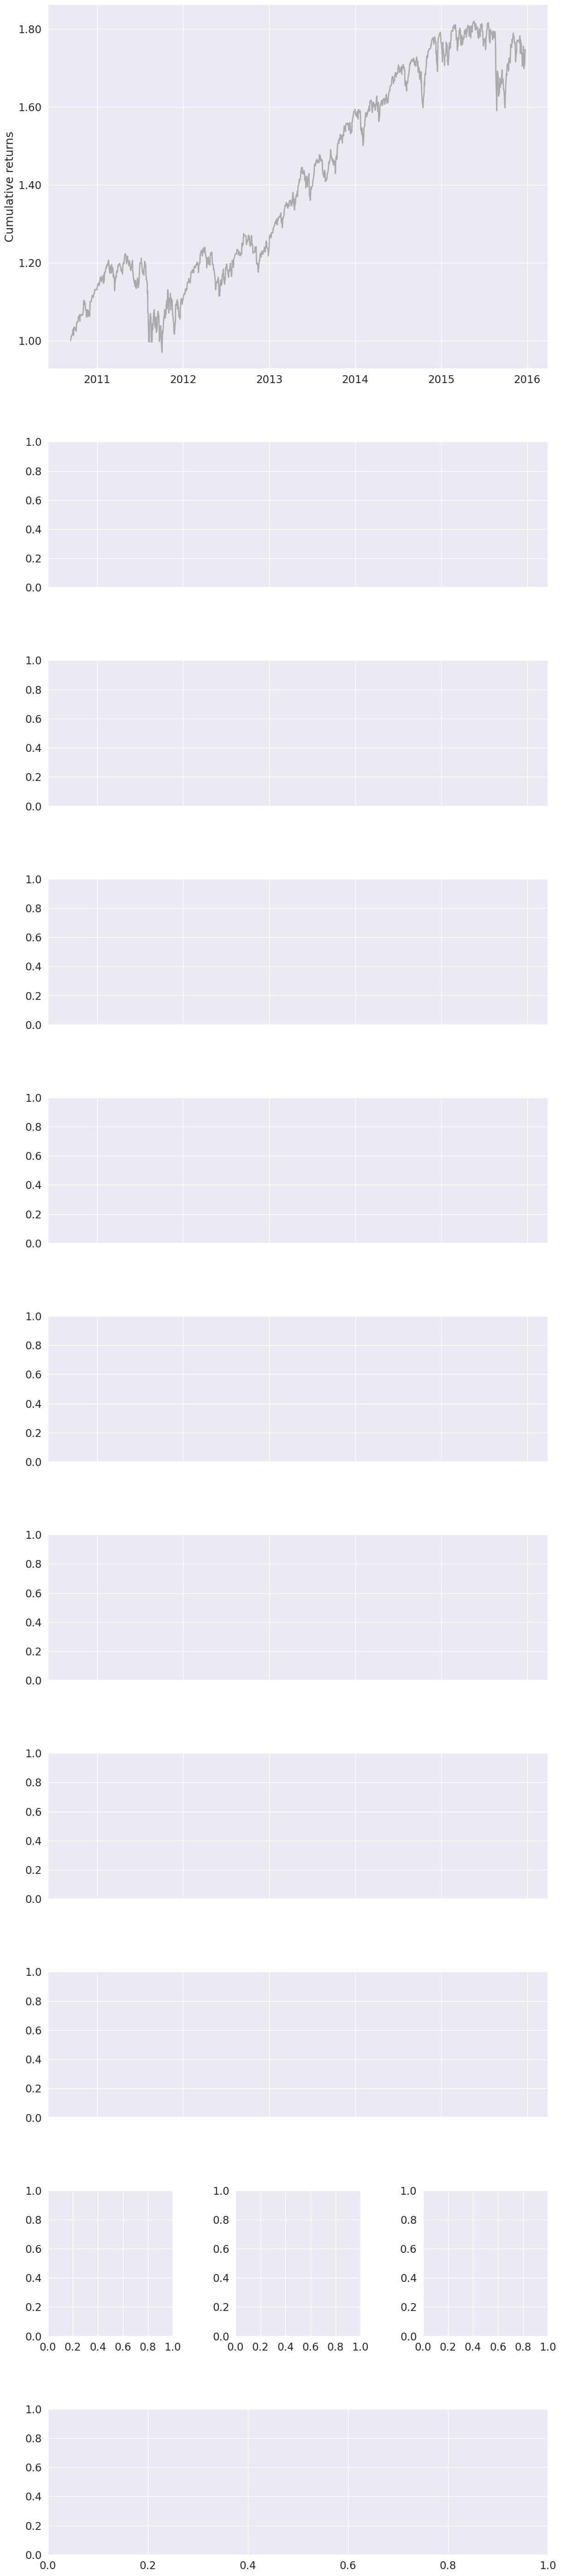

In [37]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)